## Loading the Dataset

In [3]:
import pandas as pd

data = pd.read_csv('pred_main_dataset.csv')

print(data.head())


   UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  TWF  \
0                    1551         42.8                0                0    0   
1                    1408         46.3                3                0    0   
2                    1498         49.4                5                0    0   
3                    1433         39.5                7                0    0   
4                    1408         40.0                9                0    0   

   HDF  PWF  OSF  RNF  
0    0    0    0    0  
1    0    0    0    0  
2    0  

## Data Exploration

In [4]:
# Check data types
print(data.dtypes)

# Summary statistics
print(data.describe())

# Check for missing values
print(data.isnull().sum())

UDI                          int64
Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Machine failure              int64
TWF                          int64
HDF                          int64
PWF                          int64
OSF                          int64
RNF                          int64
dtype: object
               UDI  Air temperature [K]  Process temperature [K]  \
count  10000.00000         10000.000000             10000.000000   
mean    5000.50000           300.004930               310.005560   
std     2886.89568             2.000259                 1.483734   
min        1.00000           295.300000               305.700000   
25%     2500.75000           298.300000               308.800000   
50%     5000.50000           300.100000               310.100000   
75%     7500.25000  

## Feature Engineering

In [5]:
data['Any_failure'] = data[['TWF', 'HDF', 'PWF', 'OSF', 'RNF']].max(axis=1)

### Interaction Features

In [6]:
data['Speed_Torque_Interaction'] = data['Rotational speed [rpm]'] * \
    data['Torque [Nm]']

print(data[['Rotational speed [rpm]', 'Torque [Nm]',
      'Speed_Torque_Interaction']].head())

   Rotational speed [rpm]  Torque [Nm]  Speed_Torque_Interaction
0                    1551         42.8                   66382.8
1                    1408         46.3                   65190.4
2                    1498         49.4                   74001.2
3                    1433         39.5                   56603.5
4                    1408         40.0                   56320.0


### Exploratory Data Analysis

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


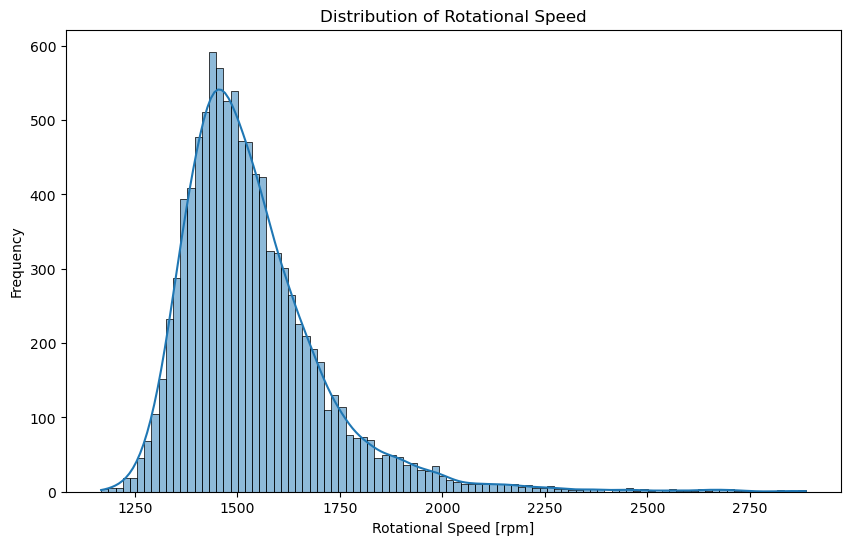

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(data['Rotational speed [rpm]'], kde=True)
plt.title('Distribution of Rotational Speed')
plt.xlabel('Rotational Speed [rpm]')
plt.ylabel('Frequency')
plt.show()

#### Visualising the Relationship Between Rotational Speed, Torque, and Machine Failure

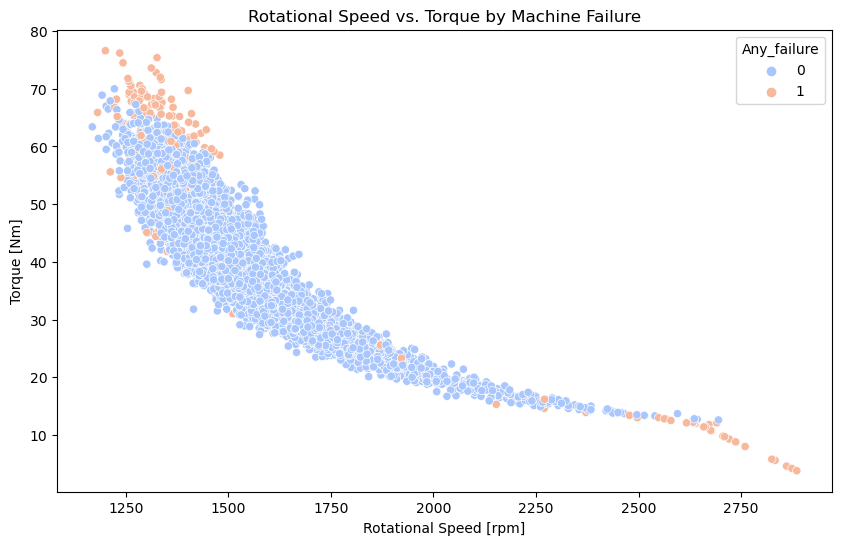

In [8]:
# Scatter plot of Rotational Speed vs. Torque, coloured by Machine Failure
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Rotational speed [rpm]', y='Torque [Nm]',
                hue='Any_failure', data=data, palette='coolwarm')
plt.title('Rotational Speed vs. Torque by Machine Failure')
plt.xlabel('Rotational Speed [rpm]')
plt.ylabel('Torque [Nm]')
plt.show()